# Documentation available at https://github.com/ChamodKalupahana/kaggle_bloomberg_news_score

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# for RNN model
import tensorflow as tf
import tensorflow.keras.layers as layers

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2023-psl-week-using-bloomberg-news/train.csv
/kaggle/input/2023-psl-week-using-bloomberg-news/test.csv


# Load dataset

In [2]:
filepath = "/kaggle/input/2023-psl-week-using-bloomberg-news/train.csv"
test_filepath = "/kaggle/input/2023-psl-week-using-bloomberg-news/test.csv"

dataset = pd.read_csv(filepath)
test_dataset = pd.read_csv(test_filepath)

In [3]:
dataset.head()

Unnamed: 0  positive  negative  indecisive     score         y
0  2010-01-04      11.0       3.0         0.0  0.571429  0.043956
1  2010-01-05       6.0       6.0         3.0  0.000000  0.042511
2  2010-01-06       7.0       3.0         1.0  0.400000  0.041065
3  2010-01-07       9.0       5.0         0.0  0.285714  0.034180
4  2010-01-08       7.0       3.0         2.0  0.400000  0.049178

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2594 entries, 0 to 2593
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2594 non-null   object 
 1   positive    2594 non-null   float64
 2   negative    2594 non-null   float64
 3   indecisive  2594 non-null   float64
 4   score       2594 non-null   float64
 5   y           2594 non-null   float64
dtypes: float64(5), object(1)
memory usage: 121.7+ KB


#### Create sum column to normalise data

In [5]:
dataset['sum'] = dataset['positive'] + dataset['negative'] + dataset['indecisive']
dataset.head(5)

Unnamed: 0  positive  negative  indecisive     score         y   sum
0  2010-01-04      11.0       3.0         0.0  0.571429  0.043956  14.0
1  2010-01-05       6.0       6.0         3.0  0.000000  0.042511  15.0
2  2010-01-06       7.0       3.0         1.0  0.400000  0.041065  11.0
3  2010-01-07       9.0       5.0         0.0  0.285714  0.034180  14.0
4  2010-01-08       7.0       3.0         2.0  0.400000  0.049178  12.0

In [6]:
# plt.plot(dataset['Unnamed: 0'], dataset['positive'])
# plt.plot(dataset['Unnamed: 0'], dataset['negative'])
# plt.plot(dataset['Unnamed: 0'], dataset['indecisive'])

In [7]:
dataset.describe()

positive     negative   indecisive        score            y  \
count  2594.000000  2594.000000  2594.000000  2594.000000  2594.000000   
mean      5.520432     5.919429     2.308019    -0.036421     0.038795   
std       2.963424     2.966854     1.823159     0.473590     0.064975   
min       0.000000     0.000000     0.000000    -1.000000    -0.234264   
25%       3.000000     4.000000     1.000000    -0.400000     0.003406   
50%       5.000000     6.000000     2.000000     0.000000     0.042638   
75%       8.000000     8.000000     3.000000     0.333333     0.081637   
max      14.000000    14.000000    10.000000     1.000000     0.254303   

               sum  
count  2594.000000  
mean     13.747880  
std       1.238462  
min       6.000000  
25%      13.000000  
50%      14.000000  
75%      15.000000  
max      15.000000

# Prepare dataset

#### Normalise each data point with the sum of positive, negative and indecisive

In [8]:
dataset['positive'] = dataset['positive'] / dataset['sum']
dataset['negative'] = dataset['negative'] / dataset['sum']
dataset['indecisive'] = dataset['indecisive'] / dataset['sum']

#### Create x and y datasets for training

In [9]:
dataset_sum = dataset.pop('sum')
y = dataset.pop('y')
x = dataset
dates = x.pop('Unnamed: 0')

In [10]:
x.head()

positive  negative  indecisive     score
0  0.785714  0.214286    0.000000  0.571429
1  0.400000  0.400000    0.200000  0.000000
2  0.636364  0.272727    0.090909  0.400000
3  0.642857  0.357143    0.000000  0.285714
4  0.583333  0.250000    0.166667  0.400000

In [11]:
y.head()

0    0.043956
1    0.042511
2    0.041065
3    0.034180
4    0.049178
Name: y, dtype: float64

#### Repeat for test dataset

In [12]:
dates = test_dataset.pop('Unnamed: 0')

test_dataset['sum'] = test_dataset['positive'] + test_dataset['negative'] + test_dataset['indecisive']

test_dataset['positive'] = test_dataset['positive'] / test_dataset['sum']
test_dataset['negative'] = test_dataset['negative'] / test_dataset['sum']
test_dataset['indecisive'] = test_dataset['indecisive'] / test_dataset['sum']

test_dataset_sum = test_dataset.pop('sum')

In [13]:
test_dataset.head()

positive  negative  indecisive     score
0  0.583333  0.250000    0.166667  0.400000
1  0.071429  0.785714    0.142857 -0.833333
2  0.500000  0.357143    0.142857  0.166667
3  0.357143  0.428571    0.214286 -0.090909
4  0.642857  0.214286    0.142857  0.500000

# Define RNN model

In [14]:
features = 1 # 1D data
input_shape = x.shape[1]

model = tf.keras.models.Sequential([
    layers.LSTM(units=128, input_shape=(input_shape, features), return_sequences=True),
    layers.LSTM(units=64, input_shape=(input_shape, features)),
    layers.Dense(units=32, activation='relu'),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=8, activation='relu'),
    layers.Dense(units=4, activation='relu'),
    layers.Dense(units=2, activation='relu'),
    layers.Dense(units=1)
])

loss_function = tf.keras.losses.MeanSquaredError()
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001) # changed lr from 0.001
model.compile(loss = loss_function, optimizer=optimiser, metrics=['mae'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 2)                 1

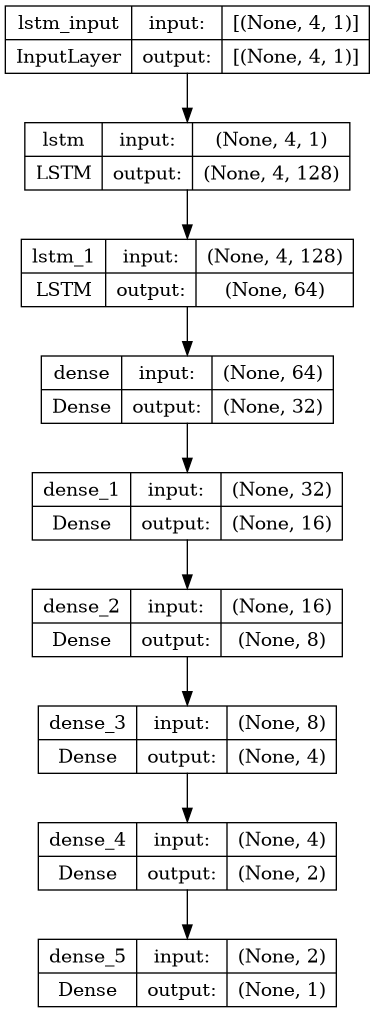

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Test dataset

In [17]:
model.fit(x, y, epochs=50, batch_size=32)

Epoch 1/50
82/82 [==============================] - 6s 11ms/step - loss: 0.0052 - mae: 0.0586
Epoch 2/50
82/82 [==============================] - 1s 10ms/step - loss: 0.0045 - mae: 0.0525
Epoch 3/50
82/82 [==============================] - 1s 11ms/step - loss: 0.0042 - mae: 0.0502
Epoch 4/50
82/82 [==============================] - 1s 10ms/step - loss: 0.0042 - mae: 0.0502
Epoch 5/50
82/82 [==============================] - 1s 10ms/step - loss: 0.0042 - mae: 0.0501
Epoch 6/50
82/82 [==============================] - 1s 10ms/step - loss: 0.0042 - mae: 0.0502
Epoch 7/50
82/82 [==============================] - 1s 10ms/step - loss: 0.0042 - mae: 0.0501
Epoch 8/50
82/82 [==============================] - 1s 10ms/step - loss: 0.0042 - mae: 0.0502
Epoch 9/50
82/82 [==============================] - 1s 11ms/step - loss: 0.0042 - mae: 0.0501
Epoch 10/50
82/82 [==============================] - 1s 10ms/step - loss: 0.0042 - mae: 0.0501
Epoch 11/50
82/82 [==============================] - 1s 10m

# Generate submission

In [18]:
predictions = model.predict(test_dataset)

30/30 [==============================] - 1s 4ms/step


#### Submission only need dates and y columns

In [19]:
submission = pd.DataFrame()
submission['date'] = dates
submission['y'] = predictions

In [20]:
submission.head()

date         y
0  2020-01-02  0.037865
1  2020-01-03  0.038792
2  2020-01-06  0.038066
3  2020-01-07  0.038167
4  2020-01-08  0.037827

In [21]:
submission.describe()

y
count  957.000000
mean     0.038188
std      0.000401
min      0.037028
25%      0.037894
50%      0.038225
75%      0.038494
max      0.039030

In [22]:
submission.to_csv('/kaggle/working/submission.csv',index=False,header=True)